In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import datetime
import seaborn as sns
import pydicom
import time
import gc
import operator 
from apex import amp 
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.utils.data as D
import torch.nn.functional as F
from sklearn.model_selection import KFold
from tqdm import tqdm, tqdm_notebook
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import warnings
warnings.filterwarnings(action='once')
import pickle
%load_ext autoreload
%autoreload 2
%matplotlib inline
from skimage.io import imread,imshow
from helper import *
from apex import amp
import helper
import torchvision.models as models
from torch.optim import Adam
from defenitions import *

/home/reina/anaconda3/envs/RSNA/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/home/reina/anaconda3/envs/RSNA/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


In [2]:
SEED = 43564
device=device_by_name("Tesla")
#device=device_by_name("RTX")
#device = "cpu"

In [3]:
train_df = pd.read_csv(data_dir+'train.csv')
train_df.head()

,PatientID,epidural,intraparenchymal,intraventricular,subarachnoid,subdural,any,PID,StudyI,SeriesI,WindowCenter,WindowWidth,ImagePositionZ,ImagePositionX,ImagePositionY
0,63eb1e259,0,0,0,0,0,0,a449357f,62d125e5b2,0be5c0d1b3,"['00036', '00036']","['00080', '00080']",180.199951,-125.0,-8.000000
1,2669954a7,0,0,0,0,0,0,363d5865,a20b80c7bf,3564d584db,"['00047', '00047']","['00080', '00080']",922.530821,-156.0,45.572849
2,52c9913b1,0,0,0,0,0,0,9c2b4bd7,3e3634f8cf,973274ffc9,40,150,4.455000,-125.0,-115.063000
3,4e6ff6126,0,0,0,0,0,0,3ae81c2d,a1390c15c2,e5ccad8244,"['00036', '00036']","['00080', '00080']",100.000000,-99.5,28.500000
4,7858edd88,0,0,0,0,0,0,c1867feb,c73e81ed3a,28e0531b3a,40,100,145.793000,-125.0,-132.190000


In [4]:
split = train_df.SeriesI.unique()
np.random.seed(SEED)
np.random.shuffle(split)
split_train=split[:int(0.9*split.shape[0])]
split_val=split[int(0.9*split.shape[0]):]

idx_train = train_df[train_df.SeriesI.isin(set(split_train))].index.values
idx_validate = train_df[train_df.SeriesI.isin(set(split_val))].index.values
idx_train.shape
idx_validate.shape

In [6]:
def my_loss(y_pred,y_true,weights):
    return F.binary_cross_entropy_with_logits(y_pred,y_true,weights.repeat(y_pred.shape[0],1))

In [ ]:
class parameter_scheduler():
    def __init__(self,model,do_first=['classifier'],num_epoch=1):
        self.model=model
        self.do_first = do_first
        self.num_epoch=num_epoch
    def __call__(self,epoch):
        if epoch>=self.num_epoch:
            for n,p in self.model.named_parameters():
                p.requires_grad=True
        else:
            for n,p in self.model.named_parameters():
                p.requires_grad= any(nd in n for nd in self.do_first)


In [7]:
def get_optimizer_parameters(model,klr):
    zero_layer=['conv0','norm0']
    param_optimizer = list(model.named_parameters())
    num_blocks=4
    no_decay=['bias']
    optimizer_grouped_parameters=[
        {'params': [p for n, p in param_optimizer if (not any(nd in n for nd in no_decay) and any(nd in n for nd in zero_layer))], 'lr':klr*2e-5,'weight_decay': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)  and any(nd in n for nd in zero_layer)], 'lr':klr*2e-5, 'weight_decay': 0.0}
        ]
    optimizer_grouped_parameters.extend([
        {'params': [p for n, p in param_optimizer if (not any(nd in n for nd in no_decay) and ('classifier' in n))], 'lr':klr*1e-3,'weight_decay': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)  and ('classifier' in n)], 'lr':klr*1e-3, 'weight_decay': 0.0}
        ])
    for i in range(num_blocks):
        optimizer_grouped_parameters.extend([
        {'params': [p for n, p in param_optimizer if (not any(nd in n for nd in no_decay) and ('denseblock{}'.format(i+1) in n))], 'lr':klr*(2.0**i)*2e-5,'weight_decay': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)  and ('denseblock{}'.format(i+1) in n)], 'lr':klr*(2.0**i)*2e-5, 'weight_decay': 0.0}
        ])
    optimizer_grouped_parameters.extend([
        {'params': [p for n, p in param_optimizer if (not any(nd in n for nd in no_decay) and ('norm5' in n))], 'lr':klr*1e-4,'weight_decay': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)  and ('norm5' in n)], 'lr':klr*1e-4, 'weight_decay': 0.0}
        ])
    return(optimizer_grouped_parameters)

    

In [8]:
num_split=0
np.random.seed(SEED+num_split)
torch.manual_seed(SEED+num_split)
torch.cuda.manual_seed(SEED+num_split)
torch.backends.cudnn.deterministic = True
klr=3
batch_size=32
num_workers=12
num_epochs=3
model_name,version = 'Densenet161' , 'basic'
model = MyDenseNet(models.densenet161(pretrained=True),len(hemorrhage_types))
_=model.to(device)
weights = torch.tensor([1.,1.,1.,1.,1.,2.],device=device)
loss_func=my_loss
targets_dataset=D.TensorDataset(torch.tensor(train_df[hemorrhage_types].values,dtype=torch.float))
transform=MyTransform(flip=True,zoom=0.05,rotate=15,out_size=384,shift=40)
imagedataset = ImageDataset(train_df,transform=transform.random,base_path=train_images_dir)
transform_val=MyTransform(out_size=384)
imagedataset_val = ImageDataset(train_df,transform=transform_val.random,base_path=train_images_dir)
combined_dataset=DatasetCat([imagedataset,targets_dataset])
combined_dataset_val=DatasetCat([imagedataset_val,targets_dataset])
#param_s=parameter_scheduler(model,num_epoch=0)
optimizer_grouped_parameters=get_optimizer_parameters(model,klr)
idx_train = splits[num_split][0]
idx_validate = splits[num_split][1]
sampling=sampler(train_df[hemorrhage_types].values[idx_train],0.2,[10,1,1,1,1,0])
sample_ratio=1.02*float(sampling().shape[0])/idx_train.shape[0]
train_dataset=D.Subset(combined_dataset,idx_train)
validate_dataset=D.Subset(combined_dataset_val,idx_validate)
num_train_optimization_steps = num_epochs*(sample_ratio*len(train_dataset)//batch_size+int(len(train_dataset)%batch_size>0))
sched=WarmupExpCosineWithWarmupRestartsSchedule( t_total=num_train_optimization_steps, cycles=num_epochs//3,tau=1)
optimizer = BertAdam(optimizer_grouped_parameters,lr=klr*1e-3,schedule=sched)
history,best_model= model_train(model,
                                optimizer,
                                train_dataset,
                                batch_size,
                                num_epochs,
                                loss_func,
                                weights=weights,
                                do_apex=True,
                                validate_dataset=validate_dataset,
                                param_schedualer=model.parameter_scheduler,
                                weights_data=None,
                                metric=None,
                                return_model=True,
                                num_workers=num_workers,
                                sampler=sampling)


huston is the an empty picture 8da38f2e4
huston is the an empty picture d91d52bdc


got some error with pid {}.format(pid)
huston is the an empty picture 6431af929
{'loss': 0.07448367083100708, 'val_loss': 0.03400216749259598}


got some error with pid {}.format(pid)
huston is the an empty picture e20bf3f8a


got some error with pid {}.format(pid)
huston is the an empty picture 6431af929
{'loss': 0.031517883260945304, 'val_loss': 0.01527987809799191}


huston is the an empty picture d91d52bdc
got some error with pid {}.format(pid)
huston is the an empty picture e20bf3f8a
huston is the an empty picture 0e21abf7a


got some error with pid {}.format(pid)
huston is the an empty picture 6431af929
{'loss': 0.02393648101217016, 'val_loss': 0.014061826370990935}

0.014061826370990935


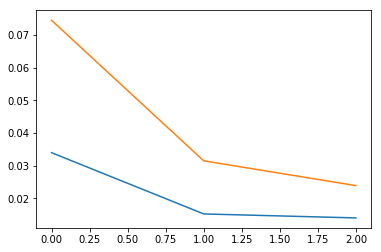

In [9]:
 plt.plot(np.array([[hist['val_loss'] for hist in history],[hist['loss'] for hist in history]]).transpose())

In [10]:
torch.save(best_model.state_dict(), models_dir+models_format.format(model_name,version,num_split))


In [9]:
num_split=0
np.random.seed(SEED+num_split)
torch.manual_seed(SEED+num_split)
torch.cuda.manual_seed(SEED+num_split)
torch.backends.cudnn.deterministic = True
klr=1
batch_size=48
num_workers=12
num_epochs=2
model_name,version = 'Densenet161' , 'basic_more'
model = MyDenseNet(models.densenet161(pretrained=True),len(hemorrhage_types))
model.load_state_dict(torch.load(models_dir+models_format.format(model_name,'basic_classifier',num_split),map_location=torch.device(device)))
_=model.to(device)
weights = torch.tensor([1.,1.,1.,1.,1.,2.],device=device)
loss_func=my_loss
targets_dataset=D.TensorDataset(torch.tensor(train_df[hemorrhage_types].values,dtype=torch.float))
transform=MyTransform(flip=True,zoom=0.05,rotate=15,out_size=384,shift=40)
imagedataset = ImageDataset(train_df,transform=transform.random,base_path=train_images_dir)
transform_val=MyTransform(out_size=384)
imagedataset_val = ImageDataset(train_df,transform=transform_val.random,base_path=train_images_dir)
combined_dataset=DatasetCat([imagedataset,targets_dataset])
combined_dataset_val=DatasetCat([imagedataset_val,targets_dataset])
#param_s=parameter_scheduler(model,num_epoch=0)
optimizer_grouped_parameters=get_optimizer_parameters(model,klr)
idx_train = splits[num_split][0]
idx_validate = splits[num_split][1]
#sampling=sampler(train_df[hemorrhage_types].values[idx_train],0.2,[10,1,1,1,1,0])
sample_ratio=1.0 #1.02*float(sampling().shape[0])/idx_train.shape[0]
train_dataset=D.Subset(combined_dataset,idx_train)
validate_dataset=D.Subset(combined_dataset_val,idx_validate)
num_train_optimization_steps = num_epochs*(sample_ratio*len(train_dataset)//batch_size+int(len(train_dataset)%batch_size>0))
sched=WarmupExpCosineWithWarmupRestartsSchedule( t_total=num_train_optimization_steps, cycles=num_epochs*2,tau=1)
optimizer = BertAdam(optimizer_grouped_parameters,lr=klr*1e-3,schedule=sched)
history,best_model= model_train(model,
                                optimizer,
                                train_dataset,
                                batch_size,
                                num_epochs,
                                loss_func,
                                weights=weights,
                                do_apex=True,
                                validate_dataset=validate_dataset,
                                param_schedualer=None,
                                weights_data=None,
                                metric=None,
                                return_model=True,
                                num_workers=num_workers,
                                sampler=None)

torch.save(best_model.state_dict(), models_dir+models_format.format(model_name,version,num_split))

{'loss': 0.07999508649283239, 'val_loss': 0.0775883376934853}


{'loss': 0.0781574439076738, 'val_loss': 0.07572695844744466}
0.07572695844744466


In [11]:
num_split=0
np.random.seed(SEED+num_split)
torch.manual_seed(SEED+num_split)
torch.cuda.manual_seed(SEED+num_split)
torch.backends.cudnn.deterministic = True
klr=3
batch_size=32
num_workers=12
num_epochs=1
model_name,version = 'Densenet161' , 'basic_more'
model1 = MyDenseNet(models.densenet161(pretrained=True),len(hemorrhage_types))
model1.load_state_dict(torch.load(models_dir+models_format.format(model_name,'basic',num_split),map_location=torch.device(device)))
model = MyDenseNet(models.densenet161(pretrained=True),len(hemorrhage_types))
model.features = model1.features
_=model.to(device)
param_optimizer = list(model.named_parameters())
no_decay=['bias']
optimizer_grouped_parameters=[
    {'params': [p for n, p in param_optimizer if (not any(nd in n for nd in no_decay) and ('classifier' in n))], 'lr':klr*1e-3,'weight_decay': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)  and ('classifier' in n)], 'lr':klr*1e-3, 'weight_decay': 0.0}
    ]
    
weights = torch.tensor([1.,1.,1.,1.,1.,2.],device=device)
loss_func=my_loss
targets_dataset=D.TensorDataset(torch.tensor(train_df[hemorrhage_types].values,dtype=torch.float))
transform=MyTransform(flip=True,zoom=0.05,rotate=15,out_size=384,shift=40)
imagedataset = ImageDataset(train_df,transform=transform.random,base_path=train_images_dir)
transform_val=MyTransform(out_size=384)
imagedataset_val = ImageDataset(train_df,transform=transform_val.random,base_path=train_images_dir)
combined_dataset=DatasetCat([imagedataset,targets_dataset])
combined_dataset_val=DatasetCat([imagedataset_val,targets_dataset])
#param_s=parameter_scheduler(model,num_epoch=0)
optimizer_grouped_parameters=get_optimizer_parameters(model,klr)
idx_train = splits[num_split][0]
idx_validate = splits[num_split][1]
#sampling=sampler(train_df[hemorrhage_types].values[idx_train],0.2,[10,1,1,1,1,0])
sample_ratio=1.0 #1.02*float(sampling().shape[0])/idx_train.shape[0]
train_dataset=D.Subset(combined_dataset,idx_train)
validate_dataset=D.Subset(combined_dataset_val,idx_validate)
num_train_optimization_steps = num_epochs*(sample_ratio*len(train_dataset)//batch_size+int(len(train_dataset)%batch_size>0))
sched=WarmupExpCosineWithWarmupRestartsSchedule( t_total=num_train_optimization_steps, cycles=num_epochs//1,tau=0)
optimizer = BertAdam(optimizer_grouped_parameters,lr=klr*1e-3,schedule=sched)
history,best_model= model_train(model,
                                optimizer,
                                train_dataset,
                                batch_size,
                                num_epochs,
                                loss_func,
                                weights=weights,
                                do_apex=True,
                                validate_dataset=validate_dataset,
                                param_schedualer=None,
                                weights_data=None,
                                metric=None,
                                return_model=True,
                                num_workers=num_workers,
                                sampler=None)

torch.save(best_model.state_dict(), models_dir+models_format.format(model_name,version,num_split))

got some error with pid {}.format(pid)
huston is the an empty picture e20bf3f8a
huston is the an empty picture 470e639ae
huston is the an empty picture d91d52bdc
huston is the an empty picture 0e21abf7a
huston is the an empty picture 8da38f2e4


got some error with pid {}.format(pid)
huston is the an empty picture 6431af929
{'loss': 0.011510233211503544, 'val_loss': 0.01142682346834119}

0.01142682346834119


In [11]:
num_split=0
np.random.seed(SEED+num_split)
torch.manual_seed(SEED+num_split)
torch.cuda.manual_seed(SEED+num_split)
torch.backends.cudnn.deterministic = True
klr=3
batch_size=32
num_workers=12
num_epochs=1
model_name,version = 'Densenet161' , 'basic_classifier'
model1 = MyDenseNet(models.densenet161(pretrained=True),len(hemorrhage_types))
model1.load_state_dict(torch.load(models_dir+models_format.format(model_name,'basic',num_split),map_location=torch.device(device)))
model = MyDenseNet(models.densenet161(pretrained=True),len(hemorrhage_types))
model.features = model1.features
_=model.to(device)
param_optimizer = list(model.named_parameters())
no_decay=['bias']
optimizer_grouped_parameters=[
    {'params': [p for n, p in param_optimizer if (not any(nd in n for nd in no_decay) and ('classifier' in n))], 'lr':klr*1e-3,'weight_decay': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)  and ('classifier' in n)], 'lr':klr*1e-3, 'weight_decay': 0.0}
    ]
    
weights = torch.tensor([1.,1.,1.,1.,1.,2.],device=device)
loss_func=my_loss
targets_dataset=D.TensorDataset(torch.tensor(train_df[hemorrhage_types].values,dtype=torch.float))
transform=MyTransform(flip=True,zoom=0.05,rotate=15,out_size=384,shift=40)
imagedataset = ImageDataset(train_df,transform=transform.random,base_path=train_images_dir)
transform_val=MyTransform(out_size=384)
imagedataset_val = ImageDataset(train_df,transform=transform_val.random,base_path=train_images_dir)
combined_dataset=DatasetCat([imagedataset,targets_dataset])
combined_dataset_val=DatasetCat([imagedataset_val,targets_dataset])
#param_s=parameter_scheduler(model,num_epoch=0)
optimizer_grouped_parameters=get_optimizer_parameters(model,klr)
idx_train = splits[num_split][0]
idx_validate = splits[num_split][1]
#sampling=sampler(train_df[hemorrhage_types].values[idx_train],0.2,[10,1,1,1,1,0])
sample_ratio=1.0 #1.02*float(sampling().shape[0])/idx_train.shape[0]
train_dataset=D.Subset(combined_dataset,idx_train)
validate_dataset=D.Subset(combined_dataset_val,idx_validate)
num_train_optimization_steps = num_epochs*(sample_ratio*len(train_dataset)//batch_size+int(len(train_dataset)%batch_size>0))
sched=WarmupExpCosineWithWarmupRestartsSchedule( t_total=num_train_optimization_steps, cycles=num_epochs//1,tau=0)
optimizer = BertAdam(optimizer_grouped_parameters,lr=klr*1e-3,schedule=sched)
history,best_model= model_train(model,
                                optimizer,
                                train_dataset,
                                batch_size,
                                num_epochs,
                                loss_func,
                                weights=weights,
                                do_apex=True,
                                validate_dataset=validate_dataset,
                                param_schedualer=None,
                                weights_data=None,
                                metric=None,
                                return_model=True,
                                num_workers=num_workers,
                                sampler=None)

torch.save(best_model.state_dict(), models_dir+models_format.format(model_name,version,num_split))

got some error with pid {}.format(pid)
huston is the an empty picture e20bf3f8a
huston is the an empty picture 470e639ae
huston is the an empty picture d91d52bdc
huston is the an empty picture 0e21abf7a
huston is the an empty picture 8da38f2e4


got some error with pid {}.format(pid)
huston is the an empty picture 6431af929
{'loss': 0.011510233211503544, 'val_loss': 0.01142682346834119}

0.01142682346834119


0.07998776427838833

In [10]:
sample_submission=pd.read_csv(data_dir+'stage_1_sample_submission.csv')
sample_submission.head()
test_df=sample_submission.copy()
test_df['Sub_type'] = test_df['ID'].str.split("_", n = 3, expand = True)[2]
test_df['PatientID'] = test_df['ID'].str.split("_", n = 3, expand = True)[1]
test_df.head()

,ID,Label
0,ID_28fbab7eb_epidural,0.5
1,ID_28fbab7eb_intraparenchymal,0.5
2,ID_28fbab7eb_intraventricular,0.5
3,ID_28fbab7eb_subarachnoid,0.5
4,ID_28fbab7eb_subdural,0.5


,ID,Label,Sub_type,PatientID
0,ID_28fbab7eb_epidural,0.5,epidural,28fbab7eb
1,ID_28fbab7eb_intraparenchymal,0.5,intraparenchymal,28fbab7eb
2,ID_28fbab7eb_intraventricular,0.5,intraventricular,28fbab7eb
3,ID_28fbab7eb_subarachnoid,0.5,subarachnoid,28fbab7eb
4,ID_28fbab7eb_subdural,0.5,subdural,28fbab7eb


In [11]:
test_Id_df = pd.DataFrame(data={'PatientID':test_df.PatientID.unique()})
test_Id_df.head()

,PatientID
0,28fbab7eb
1,877923b8b
2,a591477cb
3,42217c898
4,a130c4d2f


In [12]:
model.load_state_dict(torch.load(models_dir+models_format.format(model_name,'basic_more',num_split),map_location=torch.device(device)))
_=model.to(device)
imagedataset_test=ImageDataset(test_Id_df,transform=transform_val.random,base_path=test_images_dir)
pred = model_run(model,imagedataset_test,do_apex=True,batch_size=64,num_workers=12)

In [14]:
sub_num=5

epidural_df=pd.DataFrame(data={'ID':'ID_'+test_Id_df.PatientID.values+'_epidural','Label':torch.sigmoid(pred[:,0])})
intraparenchymal_df=pd.DataFrame(data={'ID':'ID_'+test_Id_df.PatientID.values+'_intraparenchymal','Label':torch.sigmoid(pred[:,1])})
intraventricular_df=pd.DataFrame(data={'ID':'ID_'+test_Id_df.PatientID.values+'_intraventricular','Label':torch.sigmoid(pred[:,2])})
subarachnoid_df=pd.DataFrame(data={'ID':'ID_'+test_Id_df.PatientID.values+'_subarachnoid','Label':torch.sigmoid(pred[:,3])})
subdural_df=pd.DataFrame(data={'ID':'ID_'+test_Id_df.PatientID.values+'_subdural','Label':torch.sigmoid(pred[:,4])})
any_df=pd.DataFrame(data={'ID':'ID_'+test_Id_df.PatientID.values+'_any','Label':torch.sigmoid(pred[:,5])})

test_res_df = pd.concat([epidural_df,
                        intraparenchymal_df,
                        intraventricular_df,
                        subarachnoid_df,
                        subdural_df,
                        any_df]).reset_index(drop=True)
trd=test_res_df.sort_values('ID')
sample_submission[['ID','Label']]=trd.values[np.argsort(np.argsort(sample_submission.ID.values))]
sample_submission.to_csv('/media/hd/notebooks/data/RSNA/submissions/submission{}.csv'.format(sub_num),
                                                                  index=False, columns=['ID','Label'])
sample_submission.head(10)

,ID,Label
0,ID_28fbab7eb_epidural,3.033406e-11
1,ID_28fbab7eb_intraparenchymal,6.375548e-07
2,ID_28fbab7eb_intraventricular,1.966767e-09
3,ID_28fbab7eb_subarachnoid,5.399497e-08
4,ID_28fbab7eb_subdural,1.490849e-07
5,ID_28fbab7eb_any,1.532611e-05
6,ID_877923b8b_epidural,4.363462e-09
7,ID_877923b8b_intraparenchymal,1.888572e-06
8,ID_877923b8b_intraventricular,4.644881e-09
9,ID_877923b8b_subarachnoid,8.013500e-06


In [17]:
submission_121=pd.read_csv('/media/hd/notebooks/data/RSNA/submissions/submission1.csv')

In [20]:
sample_submission.Label=(sample_submission.Label+submission_121.Label)/2
sample_submission.head()

,ID,Label
0,ID_28fbab7eb_epidural,0.000001
1,ID_28fbab7eb_intraparenchymal,0.000016
2,ID_28fbab7eb_intraventricular,0.000003
3,ID_28fbab7eb_subarachnoid,0.000103
4,ID_28fbab7eb_subdural,0.000105


In [21]:
sub_num=4
sample_submission.to_csv('/media/hd/notebooks/data/RSNA/submissions/submission{}.csv'.format(sub_num),
                                                                  index=False, columns=['ID','Label'])
